# Introduccion

Este proyecto se ha centrado en desarrollar un modelo de machine learning capaz de predecir el estado funcional de las bombas de agua en diferentes regiones de Tanzania. El objetivo principal es lograr predecir el estado de las bombas de agua dentro de tres categorías: 'functional' (operativa), 'non functional' (no operativa) o 'functional needs repair' (necesita reparación). 

El primer paso es importar las librerías.

In [166]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import re
from datetime import datetime
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC, SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import stats
import plotly.express as px
import plotly.graph_objects as go
import mlflow
sns.set()
get_ipython().run_line_magic('matplotlib', 'inline')

# Cargamos los datasets con la información detallada

In [167]:
X_train = pd.read_csv("C:/Users/estel/OneDrive/Desktop/Máster/Machine Learning/Proyecto/X_train.csv")
Y_train = pd.read_csv("C:/Users/estel/OneDrive/Desktop/Máster/Machine Learning/Proyecto/Y_train.csv")
X_test = pd.read_csv("C:/Users/estel/OneDrive/Desktop/Máster/Machine Learning/Proyecto/X_test.csv")

In [ ]:
print('Tamaño de tabla de X_train:',X_train.shape[0])
print('Tamaño de tabla de Y_train:',Y_train.shape[0])
print('Tamaño de tabla de X_test:',X_test.shape[0])

In [169]:
# Verificamos si las bombas son únicas en cada tabla

len(X_train['id'].unique()) 

59400

In [170]:
len(Y_train['id'].unique()) 

59400

In [171]:
len(X_test['id'].unique()) 

14850

In [172]:
# Visualizamos las tablas para obtener una idea de las variables y tipos de datos

X_train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [173]:
Y_train.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [174]:
X_test.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,...,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,...,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
4,49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,...,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


In [175]:
# Investigamos la posibilidad de que las mismas bombas se encuentren dentro de los diferentes datasets cargados

# Cuántas de las bombas que tienes en X_train también tienen registros en tu tabla de Y_train
print('Bombas presentes en X_train e Y_train\n', X_train['id'].isin(Y_train['id']).value_counts())

# Sí están contenidas ya que salen todas las variables como True, 59400 

# Cuántas de las bombas que tienes en X_train también tienen registros en tu tabla de X_test
print('Bombas presentes en X_train y X_test\n', X_train['id'].isin(X_test['id']).value_counts())

# No hay porque no tiene sentido que el conjunto X_train tenga bombas iguales que en el X_test

Bombas presentes en X_train e Y_train
 id
True    59400
Name: count, dtype: int64
Bombas presentes en X_train y X_test
 id
False    59400
Name: count, dtype: int64


In [176]:
#Vemos si existen nulos en el X_train, X_test e Y_train

X_train.isnull().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3637
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     2
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3878
scheme_name              28810
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

In [177]:
X_test.isnull().sum()

id                          0
amount_tsh                  0
date_recorded               0
funder                    870
gps_height                  0
installer                 877
longitude                   0
latitude                    0
wpt_name                    0
num_private                 0
basin                       0
subvillage                 99
region                      0
region_code                 0
district_code               0
lga                         0
ward                        0
population                  0
public_meeting            821
recorded_by                 0
scheme_management         969
scheme_name              7242
permit                    737
construction_year           0
extraction_type             0
extraction_type_group       0
extraction_type_class       0
management                  0
management_group            0
payment                     0
payment_type                0
water_quality               0
quality_group               0
quantity  

La cantidad de nulos de las variables X_train y X_test no coinciden. A su vez, coinciden las variables a las que les faltan nulos (excepto por la variable "wpt_name" de X_train, que tiene 2 nulos y en X_test no tiene)

Para poder gestionar los nulos se van a tratar de manera independiente X_train y X_test, aplicando las mismas normas para eliminar o imputar nulos que pertenezcan a la misma variable (así se evitan errores o inconsistencias entre ambas tablas de datos) 

In [178]:
Y_train.isnull().sum()

id              0
status_group    0
dtype: int64

Como sabemos que Y_train no tiene nulos y sus id se corresponden con los id de X_train podemos juntar ambas tablas con un left join, creando una tabla principal llamada X_Y_train.

In [179]:
X_Y_train = pd.merge(X_train, Y_train, on = "id", how = "left")

In [180]:
# La mostramos
X_Y_train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [181]:
# Vemos su tamaño
X_Y_train.shape

(59400, 41)

# Pre procesado y  limpieza de los datos

In [182]:
# Vemos información sobre el tipo de variables que hay en la tabla principal

X_Y_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55763 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59398 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

Existen muchas variables objeto y varias variables con nulos

In [183]:
# Dividimos las variables numéricas (num_cols) y categóricas (cat_cols) para proceder al tratamiento de los nulos y posteriormente visualizamos sus datos

cat_cols= X_Y_train.select_dtypes(include=['object','category']).columns
num_cols = X_Y_train.select_dtypes(exclude=['object','category']).columns

In [184]:
(X_Y_train[cat_cols].describe().T)

,count,unique,top,freq
date_recorded,59400,356,2011-03-15,572
funder,55763,1896,Government Of Tanzania,9084
installer,55745,2145,DWE,17402
wpt_name,59398,37399,none,3563
basin,59400,9,Lake Victoria,10248
subvillage,59029,19287,Madukani,508
region,59400,21,Iringa,5294
lga,59400,125,Njombe,2503
ward,59400,2092,Igosi,307
public_meeting,56066,2,True,51011


In [185]:
(X_Y_train[num_cols].describe().T)

,count,mean,std,min,25%,50%,75%,max
id,59400.0,37115.131768,21453.128371,0.00000,18519.750000,37061.500000,55656.500000,7.424700e+04
amount_tsh,59400.0,317.650385,2997.574558,0.00000,0.000000,0.000000,20.000000,3.500000e+05
gps_height,59400.0,668.297239,693.116350,-90.00000,0.000000,369.000000,1319.250000,2.770000e+03
longitude,59400.0,34.077427,6.567432,0.00000,33.090347,34.908743,37.178387,4.034519e+01
latitude,59400.0,-5.706033,2.946019,-11.64944,-8.540621,-5.021597,-3.326156,-2.000000e-08
num_private,59400.0,0.474141,12.236230,0.00000,0.000000,0.000000,0.000000,1.776000e+03
region_code,59400.0,15.297003,17.587406,1.00000,5.000000,12.000000,17.000000,9.900000e+01
district_code,59400.0,5.629747,9.633649,0.00000,2.000000,3.000000,5.000000,8.000000e+01
population,59400.0,179.909983,471.482176,0.00000,0.000000,25.000000,215.000000,3.050000e+04
construction_year,59400.0,1300.652475,951.620547,0.00000,0.000000,1986.000000,2004.000000,2.013000e+03


## Tratamiento de valores nulos para X_Y_train

In [186]:
# Mostramos los valores nulos de la tabla
X_Y_train.isnull().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3637
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     2
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3878
scheme_name              28810
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

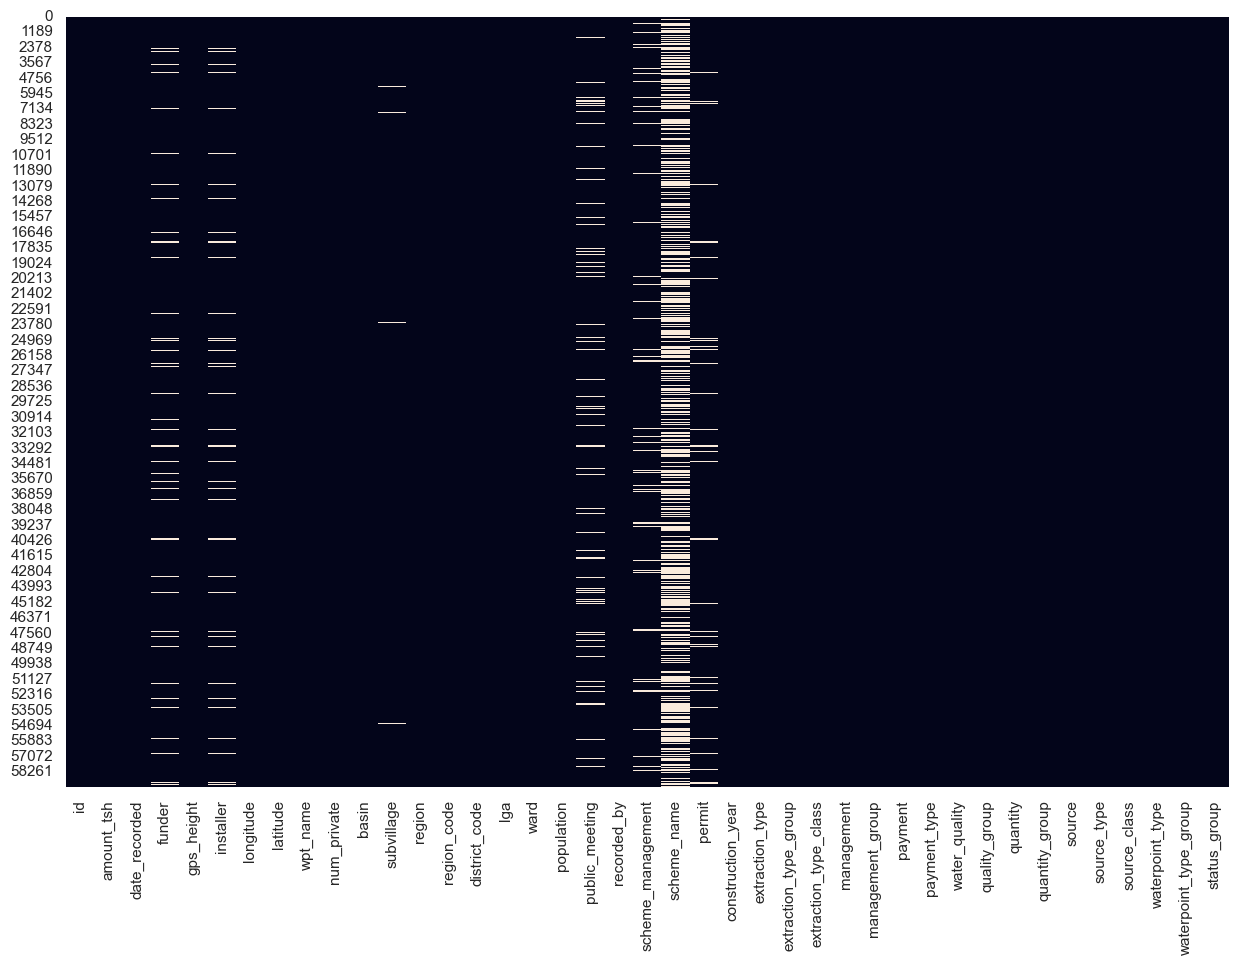

In [187]:
# Identificamos los nulos visualmente
plt.figure(figsize=(15, 10))
sns.heatmap(X_Y_train.isnull(), cbar=False)
plt.show()

Parece que los nulos de funder e installer están relacionados entre sí (la mayoría de nulos de uno están presentes cuando hay nulos en el otro)

In [188]:
print("Valores únicos en la columna 'public_meeting':", X_Y_train['public_meeting'].nunique())
print("Valores únicos en la columna 'public_meeting':", X_Y_train['public_meeting'].unique())
print("Valores únicos en la columna 'permit':", X_Y_train['permit'].nunique())
print("Valores únicos en la columna 'permit':", X_Y_train['permit'].unique())

Valores únicos en la columna 'public_meeting': 2
Valores únicos en la columna 'permit': 2
Valores únicos en la columna 'public_meeting': [True nan False]
Valores únicos en la columna 'permit': [False True nan]


Sabemos que los valores únicos de Public meeting y Permit son True, False o nan (en el caso de los nulos). Podemos tratarlos de la misma forma a la hora de imputar los nulos (en proporción a la cantidad de True y False que existen)

In [189]:
# Calculamos el porcentaje de True y False para cada variable

X_Y_train['permit'].value_counts(normalize=True)

permit
True     0.68955
False    0.31045
Name: proportion, dtype: float64

In [190]:
# Imputamos permit en X_Y_train

proporcion_true_permit = 0.68955
nulos_permit_train = X_Y_train['permit'].isnull()
n_nulos_permit_train = nulos_permit_train.sum()
valores_aleatorios_permit_train = np.random.choice([True, False], size=n_nulos_permit_train, p=[proporcion_true_permit, 1 - proporcion_true_permit])
X_Y_train.loc[nulos_permit_train, 'permit'] = valores_aleatorios_permit_train

In [191]:
# Verificar que ya no hay nulos

print("Cantidad de nulos tras la imputación en X_Y_train:", X_Y_train['permit'].isnull().sum())

Cantidad de nulos tras la imputación en X_Y_train: 0


In [192]:
# Podemos ver el porcentaje final de True y False tras la imputación (cambia de manera muy ligera)
X_Y_train['permit'].value_counts(normalize=True)

permit
True     0.689731
False    0.310269
Name: proportion, dtype: float64

In [193]:
# Hacemos los mismo con public meeting

X_Y_train['public_meeting'].value_counts(normalize=True)

public_meeting
True     0.909838
False    0.090162
Name: proportion, dtype: float64

In [194]:
# Imputamos public_meeting en X_Y_train
proporcion_true_public_meeting = 0.909838
nulos_public_meeting_train = X_Y_train['public_meeting'].isnull()
n_nulos_public_meeting_train = nulos_public_meeting_train.sum()
valores_aleatorios_public_meeting_train = np.random.choice([True, False], size=n_nulos_public_meeting_train, p=[proporcion_true_public_meeting, 1 - proporcion_true_public_meeting])
X_Y_train.loc[nulos_public_meeting_train, 'public_meeting'] = valores_aleatorios_public_meeting_train

In [195]:
# Verificar que ya no hay nulos
print("Cantidad de nulos tras la imputación en X_Y_train:", X_Y_train['public_meeting'].isnull().sum())

Cantidad de nulos tras la imputación en X_Y_train: 0


In [196]:
# Podemos ver el porcentaje final de True y False tras la imputación (también cambia de manera muy ligera)
X_Y_train['public_meeting'].value_counts(normalize=True)

public_meeting
True     0.909949
False    0.090051
Name: proportion, dtype: float64

Una vez tenemos estas 2 variables sin nulos, nos fijamos en el resto.

In [197]:
# Vemos cuáles son el número de valores únicos de cada variable con nulos

print("Valores únicos en la columna 'funder':", X_Y_train['funder'].nunique())
print("Valores únicos en la columna 'installer':", X_Y_train['installer'].nunique())
print("Valores únicos en la columna 'wpt_name':", X_Y_train['wpt_name'].nunique())
print("Valores únicos en la columna 'subvillage':", X_Y_train['subvillage'].nunique())
print("Valores únicos en la columna 'scheme_management':", X_Y_train['scheme_management'].nunique())
print("Valores únicos en la columna 'scheme_name':", X_Y_train['scheme_name'].nunique())

Valores únicos en la columna 'funder': 1896
Valores únicos en la columna 'installer': 2145
Valores únicos en la columna 'wpt_name': 37399
Valores únicos en la columna 'subvillage': 19287
Valores únicos en la columna 'scheme_management': 11
Valores únicos en la columna 'scheme_name': 2695


In [198]:
# Empezamos con scheme_management

print(X_Y_train.scheme_management.value_counts())

scheme_management
VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
Name: count, dtype: int64


In [199]:
# Vamos a imputar los valores nulos por la moda ya que hay gran diferencia de cantidad entre el primer rol (WHC) y el resto, siendo una manera sencilla
# y rápida que evita sesgos.

X_Y_train['scheme_management'].fillna('VWC',inplace=True)

C:\Users\estel\AppData\Local\Temp\ipykernel_20352\264833305.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_Y_train['scheme_management'].fillna('VWC',inplace=True)


In [200]:
# Verificar que ya no hay nulos
print("Cantidad de nulos tras la imputación en X_Y_train:", X_Y_train['scheme_management'].isnull().sum())

Cantidad de nulos tras la imputación en X_Y_train: 0


In [201]:
# Para wtp_name el documento pdf indica que si existe un nombre este se verá reflejado en los datos. Por lo tanto, los nulos existentes son nulos porque 
# no hay un nombre y no porque no se sepa.

# Sustituimos los 2 nulos por "No name"
X_Y_train['wpt_name'].fillna('No name', inplace=True)

C:\Users\estel\AppData\Local\Temp\ipykernel_20352\2544809519.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_Y_train['wpt_name'].fillna('No name', inplace=True)


In [202]:
# Verificar que ya no hay nulos
print("Cantidad de nulos tras la imputación en X_Y_train:", X_Y_train['wpt_name'].isnull().sum())

Cantidad de nulos tras la imputación en X_Y_train: 0


Para tratar las variables con gran cantidad de valores nulos y de valores únicos vamos a imputarlos como "missing"

In [203]:
# Las variables Funder, Installer, Subvillage y Scheme_name tienen muchos nulos y valores únicos, por lo que una manera sencilla de darles valor es 
# nombrar a esos nulos como una categoría a parte (missing).

# Imputamos funder, installer, subvillage y scheme_name con 'missing', uno por uno para tener más control de lo que se hace
X_Y_train['funder'].fillna('missing', inplace=True)
X_Y_train['installer'].fillna('missing', inplace=True)
X_Y_train['subvillage'].fillna('missing', inplace=True)
X_Y_train['scheme_name'].fillna('missing', inplace=True)

# Verificar que ya no hay nulos
print("Cantidad de nulos tras la imputación en X_Y_train:", X_Y_train['funder'].isnull().sum())
print("Cantidad de nulos tras la imputación en X_Y_train:", X_Y_train['installer'].isnull().sum())
print("Cantidad de nulos tras la imputación en X_Y_train:", X_Y_train['subvillage'].isnull().sum())
print("Cantidad de nulos tras la imputación en X_Y_train:", X_Y_train['scheme_name'].isnull().sum())

Cantidad de nulos tras la imputación en X_Y_train: 0
Cantidad de nulos tras la imputación en X_Y_train: 0
Cantidad de nulos tras la imputación en X_Y_train: 0
Cantidad de nulos tras la imputación en X_Y_train: 0


C:\Users\estel\AppData\Local\Temp\ipykernel_20352\370648676.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_Y_train['funder'].fillna('missing', inplace=True)
C:\Users\estel\AppData\Local\Temp\ipykernel_20352\370648676.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For ex

In [204]:
# Verificamos si ya no hay nulos en X_Y_train
X_Y_train.isnull().sum()

id                       0
amount_tsh               0
date_recorded            0
funder                   0
gps_height               0
installer                0
longitude                0
latitude                 0
wpt_name                 0
num_private              0
basin                    0
subvillage               0
region                   0
region_code              0
district_code            0
lga                      0
ward                     0
population               0
public_meeting           0
recorded_by              0
scheme_management        0
scheme_name              0
permit                   0
construction_year        0
extraction_type          0
extraction_type_group    0
extraction_type_class    0
management               0
management_group         0
payment                  0
payment_type             0
water_quality            0
quality_group            0
quantity                 0
quantity_group           0
source                   0
source_type              0
s

# Tratamiento de valores nulos para X_test
Se van a seguir las mismas técnicas de imputación que en X_Y_train para evitar sesgos a la hora de modelar

In [205]:
X_test.isnull().sum()

id                          0
amount_tsh                  0
date_recorded               0
funder                    870
gps_height                  0
installer                 877
longitude                   0
latitude                    0
wpt_name                    0
num_private                 0
basin                       0
subvillage                 99
region                      0
region_code                 0
district_code               0
lga                         0
ward                        0
population                  0
public_meeting            821
recorded_by                 0
scheme_management         969
scheme_name              7242
permit                    737
construction_year           0
extraction_type             0
extraction_type_group       0
extraction_type_class       0
management                  0
management_group            0
payment                     0
payment_type                0
water_quality               0
quality_group               0
quantity  

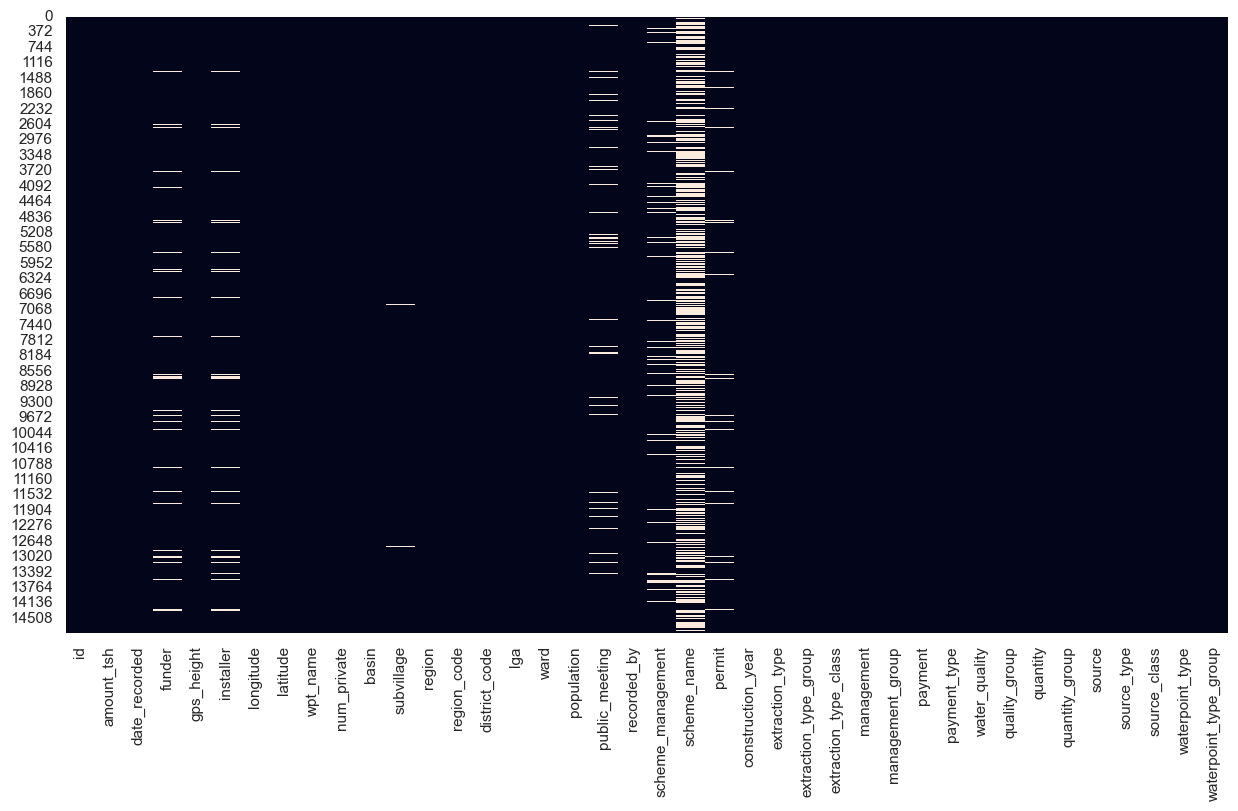

In [206]:
# Identificamos los nulos visualmente
plt.figure(figsize=(15, 8))
sns.heatmap(X_test.isnull(), cbar=False)
plt.show()

Al igual que pasa con X_Y_train, los valores funder e installer parecen estar relacionados entre sí. El resto de valores parecen nulos de manera random.

In [207]:
print("Valores únicos en la columna 'public_meeting':", X_test['public_meeting'].nunique())
print("Valores únicos en la columna 'public_meeting':", X_test['public_meeting'].unique())
print("Valores únicos en la columna 'permit':", X_test['permit'].nunique())
print("Valores únicos en la columna 'permit':", X_test['permit'].unique())

Valores únicos en la columna 'public_meeting': 2
Valores únicos en la columna 'permit': 2
Valores únicos en la columna 'public_meeting': [True nan False]
Valores únicos en la columna 'permit': [True nan False]


In [208]:
X_test['permit'].value_counts(normalize=True)

permit
True     0.691136
False    0.308864
Name: proportion, dtype: float64

In [209]:
# Imputamos permit en X_test
proporcion_true_permit = 0.691136
nulos_permit_test = X_test['permit'].isnull()
n_nulos_permit_test = nulos_permit_test.sum()
valores_aleatorios_permit_test = np.random.choice([True, False], size=n_nulos_permit_test, p=[proporcion_true_permit, 1 - proporcion_true_permit])
X_test.loc[nulos_permit_test, 'permit'] = valores_aleatorios_permit_test

In [210]:
# Verificar que ya no hay nulos
print("Cantidad de nulos tras la imputación en X_test", X_test['permit'].isnull().sum())

Cantidad de nulos tras la imputación en X_test 0


In [211]:
X_test['public_meeting'].value_counts(normalize=True)

public_meeting
True     0.907976
False    0.092024
Name: proportion, dtype: float64

In [212]:
# Imputamos permit en X_test
proporcion_true_public_meeting = 0.907976
nulos_public_meeting_test = X_test['public_meeting'].isnull()
n_nulos_public_meeting_test = nulos_public_meeting_test.sum()
valores_aleatorios_public_meeting_test = np.random.choice([True, False], size=n_nulos_public_meeting_test, p=[proporcion_true_public_meeting, 1 - proporcion_true_public_meeting])
X_test.loc[nulos_public_meeting_test, 'public_meeting'] = valores_aleatorios_public_meeting_test

In [213]:
# Verificar que ya no hay nulos
print("Cantidad de nulos tras la imputación en X_test", X_test['public_meeting'].isnull().sum())

Cantidad de nulos tras la imputación en X_test 0


In [214]:
# Vamos con scheme_management

print(X_test.scheme_management.value_counts())

scheme_management
VWC                 9124
WUG                 1290
Water authority      822
Water Board          714
WUA                  668
Parastatal           444
Company              280
Private operator     263
Other                230
SWC                   26
Trust                 20
Name: count, dtype: int64


In [215]:
# Imputamos los valores nulos por la moda, como con X_Y_train.
X_test['scheme_management'].fillna('VWC',inplace=True)

# Verificar que ya no hay nulos
print("Cantidad de nulos tras la imputación en X_test:", X_test['scheme_management'].isnull().sum())

Cantidad de nulos tras la imputación en X_test: 0


C:\Users\estel\AppData\Local\Temp\ipykernel_20352\2422562472.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_test['scheme_management'].fillna('VWC',inplace=True)


In [216]:
# Imputamos funder, installer, subvillage y scheme_name con 'missing'
X_test['funder'].fillna('missing', inplace=True)
X_test['installer'].fillna('missing', inplace=True)
X_test['subvillage'].fillna('missing', inplace=True)
X_test['scheme_name'].fillna('missing', inplace=True)

# Verificar que ya no hay nulos
print("Cantidad de nulos tras la imputación en X_test:", X_test['funder'].isnull().sum())
print("Cantidad de nulos tras la imputación en X_test:", X_test['installer'].isnull().sum())
print("Cantidad de nulos tras la imputación en X_test:", X_test['subvillage'].isnull().sum())
print("Cantidad de nulos tras la imputación en X_test:", X_test['scheme_name'].isnull().sum())

Cantidad de nulos tras la imputación en X_test: 0
Cantidad de nulos tras la imputación en X_test: 0
Cantidad de nulos tras la imputación en X_test: 0
Cantidad de nulos tras la imputación en X_test: 0


C:\Users\estel\AppData\Local\Temp\ipykernel_20352\4206075441.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_test['funder'].fillna('missing', inplace=True)
C:\Users\estel\AppData\Local\Temp\ipykernel_20352\4206075441.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa

In [217]:
# Verificamos si ya no hay nulos en X_test
X_test.isnull().sum()

id                       0
amount_tsh               0
date_recorded            0
funder                   0
gps_height               0
installer                0
longitude                0
latitude                 0
wpt_name                 0
num_private              0
basin                    0
subvillage               0
region                   0
region_code              0
district_code            0
lga                      0
ward                     0
population               0
public_meeting           0
recorded_by              0
scheme_management        0
scheme_name              0
permit                   0
construction_year        0
extraction_type          0
extraction_type_group    0
extraction_type_class    0
management               0
management_group         0
payment                  0
payment_type             0
water_quality            0
quality_group            0
quantity                 0
quantity_group           0
source                   0
source_type              0
s

# Transformación de variables categóricas a variables numéricas

Para poder modelar necesitamos que todas las variables sean de un mismo tipo.

In [ ]:
# Primero transformamos la variable date_recorded a formato datetime en X_Y_train

X_Y_train['date_recorded'] = pd.to_datetime(X_Y_train['date_recorded'])

# Extraer el año
X_Y_train['recorded_year'] = X_Y_train['date_recorded'].dt.year

# Extraer el mes
X_Y_train['recorded_month'] = X_Y_train['date_recorded'].dt.month

# Extraer el día
X_Y_train['recorded_day'] = X_Y_train['date_recorded'].dt.day

# Eliminamos la columna original 'date_recorded' 
X_Y_train.drop('date_recorded', axis=1, inplace=True)

In [234]:
# Hacemos los mismo para X_test

X_test['date_recorded'] = pd.to_datetime(X_test['date_recorded'])

# Extraer el año
X_test['recorded_year'] = X_test['date_recorded'].dt.year

# Extraer el mes
X_test['recorded_month'] = X_test['date_recorded'].dt.month

# Extraer el día
X_test['recorded_day'] = X_test['date_recorded'].dt.day

# Eliminamos la columna original 'date_recorded' 
X_test.drop('date_recorded', axis=1, inplace=True)

In [219]:
X_Y_train.dtypes

id                         int64
amount_tsh               float64
funder                    object
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
wpt_name                  object
num_private                int64
basin                     object
subvillage                object
region                    object
region_code                int64
district_code              int64
lga                       object
ward                      object
population                 int64
public_meeting            object
recorded_by               object
scheme_management         object
scheme_name               object
permit                    object
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
payment_type              object
water_qual

In [221]:
# Extraemos las variables dummies de aquellas que tengan pocos valores únicos (ya que se formará una variable más por variable dummie que creemos) 
# y las variables biniarias de aquellas que solo tengan 2 valores únicos

variables_dummies = [
    'basin',
    'scheme_management',
    'extraction_type_class',
    'management_group',
    'payment',
    'payment_type',
    'water_quality', 
    'quality_group',
    'quantity',
    'quantity_group',
    'source_type',
    'source_class',
    'waterpoint_type',
    'waterpoint_type_group'
]  
variables_binarias = ['public_meeting','permit']

In [222]:
# Obtenemos las variables dummies de X_Y_train

for k in variables_dummies:
    dummies = pd.get_dummies(X_Y_train[k],prefix=k)
    X_Y_train = pd.concat([X_Y_train, dummies], axis=1)
    X_Y_train.drop(k, axis=1, inplace=True)

In [230]:
# Lo mismo pero con X_test
for k in variables_dummies:
    dummies = pd.get_dummies(X_test[k], prefix=k, drop_first=True)
    X_test = pd.concat([X_test, dummies], axis=1)
    X_test.drop(k, axis=1, inplace=True)

In [223]:
# Obtenemos las variables binarias del conjunto de X_Y_train

for i in variables_binarias:
    X_Y_train[i] = [1 if x == 'True' else 0 for x in X_Y_train[i]]

In [231]:
# Lo mismo para X_test

for i in variables_binarias:
    X_test[i] = [1 if x == 'True' else 0 for x in X_test[i]]

In [227]:
X_Y_train.dtypes

id                                            int64
amount_tsh                                  float64
funder                                       object
gps_height                                    int64
installer                                    object
                                             ...   
waterpoint_type_group_communal standpipe       bool
waterpoint_type_group_dam                      bool
waterpoint_type_group_hand pump                bool
waterpoint_type_group_improved spring          bool
waterpoint_type_group_other                    bool
Length: 122, dtype: object

In [235]:
X_test.dtypes

id                                         int64
amount_tsh                               float64
funder                                    object
gps_height                                 int64
installer                                 object
                                          ...   
waterpoint_type_group_improved spring       bool
waterpoint_type_group_other                 bool
recorded_year                              int32
recorded_month                             int32
recorded_day                               int32
Length: 107, dtype: object

In [236]:
# Identificamos qué variables siguen siendo de tipo objeto

print("\n--- Variables que aún son de tipo 'object' ---")
# Iterar sobre las columnas y mostrar solo las que son de tipo 'object'
for col, dtype in X_Y_train.dtypes.items():
    if dtype == 'object':
        print(f"- {col}: {dtype}")

print("\n--- Variables que aún son de tipo 'object' ---")
# Iterar sobre las columnas y mostrar solo las que son de tipo 'object'
for col, dtype in X_test.dtypes.items():
    if dtype == 'object':
        print(f"- {col}: {dtype}")


--- Variables que aún son de tipo 'object' ---
- funder: object
- installer: object
- wpt_name: object
- subvillage: object
- region: object
- lga: object
- ward: object
- recorded_by: object
- scheme_name: object
- extraction_type: object
- extraction_type_group: object
- management: object
- source: object
- status_group: object

--- Variables que aún son de tipo 'object' ---
- funder: object
- installer: object
- wpt_name: object
- subvillage: object
- region: object
- lga: object
- ward: object
- recorded_by: object
- scheme_name: object
- extraction_type: object
- extraction_type_group: object
- management: object
- source: object


In [237]:
variables_a_analizar = [
    'funder',
    'installer',
    'wpt_name',
    'subvillage',
    'region',
    'lga',
    'ward',
    'recorded_by',
    'scheme_name',
    'extraction_type',
    'extraction_type_group',
    'management',
    'source'
]

print("Número de valores únicos por variable objeto en X_Y_train:")
for variable in variables_a_analizar:
    unique_count = X_Y_train[variable].nunique()
    print(f"- {variable}: {unique_count}")

Número de valores únicos por variable objeto en X_Y_train:
- funder: 1897
- installer: 2146
- wpt_name: 37400
- subvillage: 19288
- region: 21
- lga: 125
- ward: 2092
- recorded_by: 1
- scheme_name: 2696
- extraction_type: 18
- extraction_type_group: 13
- management: 12
- source: 10


In [238]:
# Eliminamos recorded_by ya que no aporta información (solo tiene un tipo de dato que es el mismo para X_Y_train e X_test)

X_Y_train.drop('recorded_by', axis=1, inplace=True)
X_test.drop('recorded_by', axis=1, inplace=True)

In [240]:
# Probamos con agrupar los valores de funder en los 10 valores únicos más frecuentes para X_Y_train y X_test

top_n_funder = X_Y_train['funder'].value_counts().nlargest(10).index

# Agrupar en 'Other' los valores no encontrados en los 10 más frecuentes
X_Y_train['funder_grouped'] = X_Y_train['funder'].where(X_Y_train['funder'].isin(top_n_funder), 'Other')

# Agrupar en 'Other' los valores no encontrados en los 10 más frecuentes (prueba)
X_test['funder_grouped'] = X_test['funder'].where(X_test['funder'].isin(top_n_funder), 'Other')

# Mostrar los valores únicos de la nueva columna agrupada
print("Valores únicos en 'funder_grouped' (X_Y_train):", X_Y_train['funder_grouped'].nunique())
print("Valores únicos en 'funder_grouped' (X_test):", X_test['funder_grouped'].nunique())

Valores únicos en 'funder_grouped' (X_Y_train): 11
Valores únicos en 'funder_grouped' (X_test): 11


In [241]:
# Eliminamos las columnas originales (hemos creado columnas nuevas con los valores agrupados)
X_Y_train.drop('funder', axis=1, inplace=True)
X_test.drop('funder', axis=1, inplace=True)

In [242]:
# Aplicamos el mismo procedimiento para el resto de variables objeto que nos quedan, agrupándolas por diferentes tamaños
top_n = {
    'installer': 20,
    'wpt_name': 100,
    'subvillage': 100,
    'region': 15,
    'lga': 50,
    'ward': 100,
    'scheme_name': 20,
    'extraction_type': 10,  
    'extraction_type_group': 10,  
    'management': 10,  
    'source': 10  
}

variables_a_agrupar = [
    'installer',
    'wpt_name',
    'subvillage',
    'region',
    'lga',
    'ward',
    'scheme_name',
    'extraction_type',
    'extraction_type_group',
    'management',
    'source'
]

for variable in variables_a_agrupar:
    N = top_n.get(variable)
    if N is not None:
        top_n_variable = X_Y_train[variable].value_counts().nlargest(N).index
        X_Y_train[f'{variable}_grouped'] = X_Y_train[variable].where(X_Y_train[variable].isin(top_n_variable), 'Other')
        X_test[f'{variable}_grouped'] = X_test[variable].where(X_test[variable].isin(top_n_variable), 'Other')
    else:
        print(f"Advertencia: No se encontró valor de N para la variable '{variable}'.")

# Eliminamos las columnas originales

for variable in variables_a_agrupar:
     if variable in X_Y_train.columns:
         X_Y_train.drop(variable, axis=1, inplace=True)
     if variable in X_test.columns:
         X_test.drop(variable, axis=1, inplace=True)

In [243]:
# Volvemos a visualizar las variables tipo object que tenemos tras las agrupaciones

print("\n--- Variables que aún son de tipo 'object' ---")
# Iterar sobre las columnas y mostrar solo las que son de tipo 'object'
for col, dtype in X_Y_train.dtypes.items():
    if dtype == 'object':
        print(f"- {col}: {dtype}")

print("\n--- Variables que aún son de tipo 'object' ---")
# Iterar sobre las columnas y mostrar solo las que son de tipo 'object'
for col, dtype in X_test.dtypes.items():
    if dtype == 'object':
        print(f"- {col}: {dtype}")


--- Variables que aún son de tipo 'object' ---
- status_group: object
- funder_grouped: object
- installer_grouped: object
- wpt_name_grouped: object
- subvillage_grouped: object
- region_grouped: object
- lga_grouped: object
- ward_grouped: object
- scheme_name_grouped: object
- extraction_type_grouped: object
- extraction_type_group_grouped: object
- management_grouped: object
- source_grouped: object

--- Variables que aún son de tipo 'object' ---
- funder_grouped: object
- installer_grouped: object
- wpt_name_grouped: object
- subvillage_grouped: object
- region_grouped: object
- lga_grouped: object
- ward_grouped: object
- scheme_name_grouped: object
- extraction_type_grouped: object
- extraction_type_group_grouped: object
- management_grouped: object
- source_grouped: object


In [244]:
# Imprimir el número de valores únicos para las columnas agrupadas en X_Y_train

print("Valores únicos en la columna 'funder_grouped':", X_Y_train['funder_grouped'].nunique())
print("Valores únicos en la columna 'installer_grouped':", X_Y_train['installer_grouped'].nunique())
print("Valores únicos en la columna 'wpt_name_grouped':", X_Y_train['wpt_name_grouped'].nunique())
print("Valores únicos en la columna 'subvillage_grouped':", X_Y_train['subvillage_grouped'].nunique())
print("Valores únicos en la columna 'region_grouped':", X_Y_train['region_grouped'].nunique())
print("Valores únicos en la columna 'lga_grouped':", X_Y_train['lga_grouped'].nunique())
print("Valores únicos en la columna 'ward_grouped':", X_Y_train['ward_grouped'].nunique())
print("Valores únicos en la columna 'scheme_name_grouped':", X_Y_train['scheme_name_grouped'].nunique())
print("Valores únicos en la columna 'extraction_type_grouped':", X_Y_train['extraction_type_grouped'].nunique())
print("Valores únicos en la columna 'extraction_type_group_grouped':", X_Y_train['extraction_type_group_grouped'].nunique())
print("Valores únicos en la columna 'management_grouped':", X_Y_train['management_grouped'].nunique())
print("Valores únicos en la columna 'source_grouped':", X_Y_train['source_grouped'].nunique())

print("\nNúmero de valores únicos en las columnas agrupadas de X_test:")

print("Valores únicos en la columna 'funder_grouped':", X_test['funder_grouped'].nunique())
print("Valores únicos en la columna 'installer_grouped':", X_test['installer_grouped'].nunique())
print("Valores únicos en la columna 'wpt_name_grouped':", X_test['wpt_name_grouped'].nunique())
print("Valores únicos en la columna 'subvillage_grouped':", X_test['subvillage_grouped'].nunique())
print("Valores únicos en la columna 'region_grouped':", X_test['region_grouped'].nunique())
print("Valores únicos en la columna 'lga_grouped':", X_test['lga_grouped'].nunique())
print("Valores únicos en la columna 'ward_grouped':", X_test['ward_grouped'].nunique())
print("Valores únicos en la columna 'scheme_name_grouped':", X_test['scheme_name_grouped'].nunique())
print("Valores únicos en la columna 'extraction_type_grouped':", X_test['extraction_type_grouped'].nunique())
print("Valores únicos en la columna 'extraction_type_group_grouped':", X_test['extraction_type_group_grouped'].nunique())
print("Valores únicos en la columna 'management_grouped':", X_test['management_grouped'].nunique())
print("Valores únicos en la columna 'source_grouped':", X_test['source_grouped'].nunique())

Valores únicos en la columna 'funder_grouped': 11
Valores únicos en la columna 'installer_grouped': 21
Valores únicos en la columna 'wpt_name_grouped': 101
Valores únicos en la columna 'subvillage_grouped': 101
Valores únicos en la columna 'region_grouped': 16
Valores únicos en la columna 'lga_grouped': 51
Valores únicos en la columna 'ward_grouped': 101
Valores únicos en la columna 'scheme_name_grouped': 21
Valores únicos en la columna 'extraction_type_grouped': 11
Valores únicos en la columna 'extraction_type_group_grouped': 11
Valores únicos en la columna 'management_grouped': 11
Valores únicos en la columna 'source_grouped': 10

Número de valores únicos en las columnas agrupadas de X_test:
Valores únicos en la columna 'funder_grouped': 11
Valores únicos en la columna 'installer_grouped': 21
Valores únicos en la columna 'wpt_name_grouped': 101
Valores únicos en la columna 'subvillage_grouped': 101
Valores únicos en la columna 'region_grouped': 16
Valores únicos en la columna 'lga_gr

In [248]:
# Transformamos las variables con más valores únicos a numéricas a través de la codificación por frecuencia

def frequency_encode(train_df, test_df, column):
    """Codifica una columna categórica por frecuencia usando el train_df."""
    frequency_map = train_df[column].value_counts(normalize=True).to_dict()
    train_df[column + '_freq'] = train_df[column].map(frequency_map)
    test_df[column + '_freq'] = test_df[column].map(frequency_map).fillna(0)
    return train_df, test_df

columns_to_freq_encode = ['wpt_name_grouped', 'subvillage_grouped', 'ward_grouped', 'lga_grouped']

for col in columns_to_freq_encode:
    X_Y_train, X_test = frequency_encode(X_Y_train, X_test, col)
    print(f"Columna '{col}' codificada por frecuencia.")

# Eliminar las columnas originales agrupadas después de la codificación por frecuencia

X_Y_train.drop(columns=columns_to_freq_encode, inplace=True, errors='ignore')
X_test.drop(columns=columns_to_freq_encode, inplace=True, errors='ignore')

Columna 'wpt_name_grouped' codificada por frecuencia.
Columna 'subvillage_grouped' codificada por frecuencia.
Columna 'ward_grouped' codificada por frecuencia.
Columna 'lga_grouped' codificada por frecuencia.


In [250]:
# Transformamos las variables con menos valores únicos a numéricas a través del "One-hot encoding"

columnas_to_one_hot = [
    'funder_grouped', 'installer_grouped', 'region_grouped', 'scheme_name_grouped',
    'extraction_type_grouped', 'extraction_type_group_grouped',
    'management_grouped', 'source_grouped'
]

for col in columnas_to_one_hot:
    all_categories = pd.concat([X_Y_train[col], X_test[col]]).unique()
    
# Convertir la columna a tipo 'category' con todas las categorías posibles
    
    train_cat = pd.Categorical(X_Y_train[col], categories=all_categories)
    test_cat = pd.Categorical(X_test[col], categories=all_categories)

    train_dummies = pd.get_dummies(train_cat, prefix=col, drop_first=True, dtype=int)
    test_dummies = pd.get_dummies(test_cat, prefix=col, drop_first=True, dtype=int)

    X_Y_train = pd.concat([X_Y_train, train_dummies], axis=1).drop(col, axis=1, errors='ignore')
    X_test = pd.concat([X_test, test_dummies], axis=1).drop(col, axis=1, errors='ignore')

print("Columnas en X_Y_train después del one-hot encoding (primeras 20):", X_Y_train.columns.tolist()[:20])
print("\nColumnas en X_test después del one-hot encoding (primeras 20):", X_test.columns.tolist()[:20])

Columnas en X_Y_train después del one-hot encoding (primeras 20): ['id', 'amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'public_meeting', 'permit', 'construction_year', 'status_group', 'recorded_year', 'recorded_month', 'recorded_day', 'basin_Internal', 'basin_Lake Nyasa', 'basin_Lake Rukwa', 'basin_Lake Tanganyika']

Columnas en X_test después del one-hot encoding (primeras 20): ['id', 'amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'public_meeting', 'permit', 'construction_year', 'basin_Lake Nyasa', 'basin_Lake Rukwa', 'basin_Lake Tanganyika', 'basin_Lake Victoria', 'basin_Pangani', 'basin_Rufiji', 'basin_Ruvuma / Southern Coast', 'basin_Wami / Ruvu']


Ya tenemos todas las variables objeto transformadas a numéricas salvo por la variable status_group, variable del conjunto y_train que nos dice cómo se encuentra la bomba. Es la variable que queremos precedir en X_test (nuestra y_pred)

In [252]:
# Para status_group, como solo tiene 3 valores únicos vamos a sustituir estos valores por 0, 1 y 3

# Definir el mapeo de las categorías 
mapping = {'functional': 0, 'non functional': 1, 'functional needs repair': 3}

# Crear la nueva columna numérica 'status_group_encoded' 
X_Y_train['status_group_encoded'] = X_Y_train['status_group'].map(mapping)

# Separar las características (X_train) de la variable objetivo (y_train)
# Esto se hace ya que es más sencillo modelar con cada tabla separada y así se genera menos confusión.

y_train = X_Y_train['status_group_encoded']
X_train = X_Y_train.drop(['status_group', 'status_group_encoded'], axis=1, errors='ignore')

print("Primeros valores de y_train (variable objetivo numérica):")
print(y_train.head())

print("\nPrimeras filas de X_train (características numéricas):")
print(X_train.head())

Primeros valores de y_train (variable objetivo numérica):
0    0
1    0
2    0
3    1
4    0
Name: status_group_encoded, dtype: int64

Primeras filas de X_train (características numéricas):
      id  amount_tsh  gps_height  longitude   latitude  num_private  \
0  69572      6000.0        1390  34.938093  -9.856322            0   
1   8776         0.0        1399  34.698766  -2.147466            0   
2  34310        25.0         686  37.460664  -3.821329            0   
3  67743         0.0         263  38.486161 -11.155298            0   
4  19728         0.0           0  31.130847  -1.825359            0   

   region_code  district_code  population  public_meeting  ...  \
0           11              5         109               0  ...   
1           20              2         280               0  ...   
2           21              4         250               0  ...   
3           90             63          58               0  ...   
4           18              1           0            

Tras esta transformación de las variables objeto de X_train y X_test a numéricas, comprobamos que realmente no haya más variables objeto y que todas las variables sean ya numéricas.

In [258]:
print("Tipos de datos de las columnas en X_train:")
print(X_train.info)

print("\nTipos de datos de las columnas en X_test:")
print(X_test.info)

print("\nTipos de datos de las columnas en y_train:")
print(y_train.info)

Tipos de datos de las columnas en X_train:
<bound method DataFrame.info of           id  amount_tsh  gps_height  longitude   latitude  num_private  \
0      69572      6000.0        1390  34.938093  -9.856322            0   
1       8776         0.0        1399  34.698766  -2.147466            0   
2      34310        25.0         686  37.460664  -3.821329            0   
3      67743         0.0         263  38.486161 -11.155298            0   
4      19728         0.0           0  31.130847  -1.825359            0   
...      ...         ...         ...        ...        ...          ...   
59395  60739        10.0        1210  37.169807  -3.253847            0   
59396  27263      4700.0        1212  35.249991  -9.070629            0   
59397  37057         0.0           0  34.017087  -8.750434            0   
59398  31282         0.0           0  35.861315  -6.378573            0   
59399  26348         0.0         191  38.104048  -6.747464            0   

       region_code  dist

##### Llegados a este punto nos damos cuenta que la X_train tiene más columnas que la X_test, lo que nos impide poder modelar adecuadamente. Por ello se va a utilizar una técnica llamada reindexar. Esta técnica permite crear las columnas presentes en X_Y_train que no estaban en X_test, se rellenándose de ceros.

In [255]:
train_cols = X_train.columns
X_test = X_test.reindex(columns=train_cols, fill_value=0)

print("Número de columnas en X_train después de la alineación:", X_train.shape[1])
print("Número de columnas en X_test después de la alineación:", X_test.shape[1])

Número de columnas en X_train después de la alineación: 216
Número de columnas en X_test después de la alineación: 216


# Modelamos

Uso del modelo Random Forest Classifier, que es un algoritmo de aprendizaje supervisado potente y versátil para problemas de clasificación

Para estimar el rendimiento del modelo en datos no vistos antes de hacer predicciones en el conjunto de prueba, realizamos una validación cruzada estratificada (StratifiedKFold). Esto nos proporcionó una idea de cómo el modelo podría generalizar y nos dio métricas importantes como precisión (accuracy), precisión (precision), recall (exhaustividad) y F1-score.

In [266]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Crear el modelo Random Forest
model_rf = RandomForestClassifier(random_state=0)

# Estrategia de validación cruzada StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# Validación cruzada para obtener la precisión
scores_skf = cross_val_score(model_rf, X_train, y_train, cv=skf, scoring='accuracy')

print("accuracy con StratifiedKFold:", scores_skf)
print(f"accuracy promedio con StratifiedKFold: {np.mean(scores_skf):.4f}")

accuracy con StratifiedKFold: [0.80799663 0.80286195 0.81077441 0.80909091 0.81313131]
accuracy promedio con StratifiedKFold: 0.8088


In [267]:
# Obtenemos otras métricas utilizando cross_validate con StratifiedKFold
scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
cv_results_skf = cross_validate(model_rf, X_train, y_train, cv=skf, scoring=scoring)

print("Resultados de la validación cruzada con StratifiedKFold")
print(cv_results_skf)

Resultados de la validación cruzada con StratifiedKFold
{'fit_time': array([27.65245104, 27.46069837, 27.88518167, 27.3729496 , 27.64996576]), 'score_time': array([0.90758204, 0.85920882, 0.94375324, 0.80164599, 0.80147219]), 'test_accuracy': array([0.80799663, 0.80286195, 0.81077441, 0.80909091, 0.81313131]), 'test_precision_weighted': array([0.80227757, 0.79721163, 0.80391953, 0.80182487, 0.80774755]), 'test_recall_weighted': array([0.80799663, 0.80286195, 0.81077441, 0.80909091, 0.81313131]), 'test_f1_weighted': array([0.80209533, 0.79717085, 0.80408996, 0.80257375, 0.80651161])}


Una vez que tuvimos una estimación del rendimiento del modelo, entrenamos un modelo Random Forest final utilizando todo el conjunto de entrenamiento (X_train, y_train).

Utilizamos el modelo final entrenado para generar las predicciones de la variable objetivo (status_group) para las instancias en el conjunto de prueba (X_test). Estas predicciones se almacenaron en la variable y_pred_test como un array numérico. 

In [270]:
# Usamos Random Forest para obtener la predicción de y_test
final_model_rf = RandomForestClassifier(random_state=0)

# Entrenamos el modelo
final_model_rf.fit(X_train, y_train)

# Predecimos con X_test
y_pred_test = final_model_rf.predict(X_test)

print("Primeras 200 predicciones para X_test:", y_pred_test[:200])

Primeras 20 predicciones para X_test: [0 0 0 1 0 0 0 1 1 0 0 1 1 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0
 0 1 0 0 0 1 1 0 0 0 0 1 0 0 0 1 1 1 1 0 1 0 1 0 0 0 1 0 0 0 1 0 1 1 3 1 0
 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0
 1 0 0 1 1 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0 3 0 3 0 0 0 0 1 1 0 0 1 0
 1 1 0 0 1 0 1 0 0 1 0 0 0 1 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0
 1 0 1 1 0 0 0 3 0 0 1 0 1 3 0]


Finalmente, convertimos las predicciones numéricas de vuelta a las etiquetas de texto originales ('functional', 'non functional', 'functional needs repair') utilizando el mapeo inverso de la codificación que aplicamos a y_train. Luego, combinamos estas etiquetas con la columna 'id' del X_test para crear un DataFrame en el formato requerido para la entrega o análisis.

In [275]:
reverse_mapping = {0: 'functional', 1: 'non functional', 3: 'functional needs repair'}
y_pred_test_labels = [reverse_mapping[pred] for pred in y_pred_test]

# Creamos un DataFrame con el 'id' de X_test y las etiquetas de predicción
predictions_df = pd.DataFrame({'id': X_test['id'], 'status_group': y_pred_test_labels})

# Imprimimos las primeras filas del DataFrame de predicciones
print(predictions_df.head(20))

       id    status_group
0   50785      functional
1   51630      functional
2   17168      functional
3   45559  non functional
4   49871      functional
5   52449      functional
6   24806      functional
7   28965  non functional
8   36301  non functional
9   54122      functional
10    419      functional
11  45750  non functional
12    653  non functional
13  14017  non functional
14  44607      functional
15  40228      functional
16  27714      functional
17  28785      functional
18  28330      functional
19  18532  non functional
20  69961      functional
21  55083      functional
22   8691  non functional
23  30331  non functional
24  70970      functional
25  61136      functional
26  28799      functional
27  46825      functional
28  44718      functional
29  37350      functional
30  65738      functional
31   3271  non functional
32  42658  non functional
33  67523      functional
34  37034      functional
35  42432      functional
36  27420      functional
37    707   

In [276]:
# Guardamos el DataFrame predictions_df en un archivo CSV 
predictions_df.to_csv('y_pred.csv', index=False, sep=',')

La score en la competición de este modelo ha sido 0.7643. El modelo logró una precisión del 76.43% al predecir el estado funcional de las bombas de agua en los datos no vistos del conjunto de prueba